
2D LOSS LANDSCAPE VISUALIZATION (QUICK RUN)

Using device: cuda

Loading CIFAR-10...

EXPERIMENT 1: Plain CNN Landscape (QUICK)

Training for 1 epochs...


Epoch 1: Train Acc=39.47%, Test Acc=55.59%

GENERATING 2D LOSS LANDSCAPE

Applying filter normalization...
✓ Filter normalization applied

Evaluating loss at 121 points...


Grid evaluation: 100%|██████████| 121/121 [00:08<00:00, 14.93it/s]


✓ Landscape generation complete!
  Min loss: 1.2215
  Max loss: 3.4397
  Mean loss: 1.7875

Plot saved to landscape_plain_cnn_quick.png


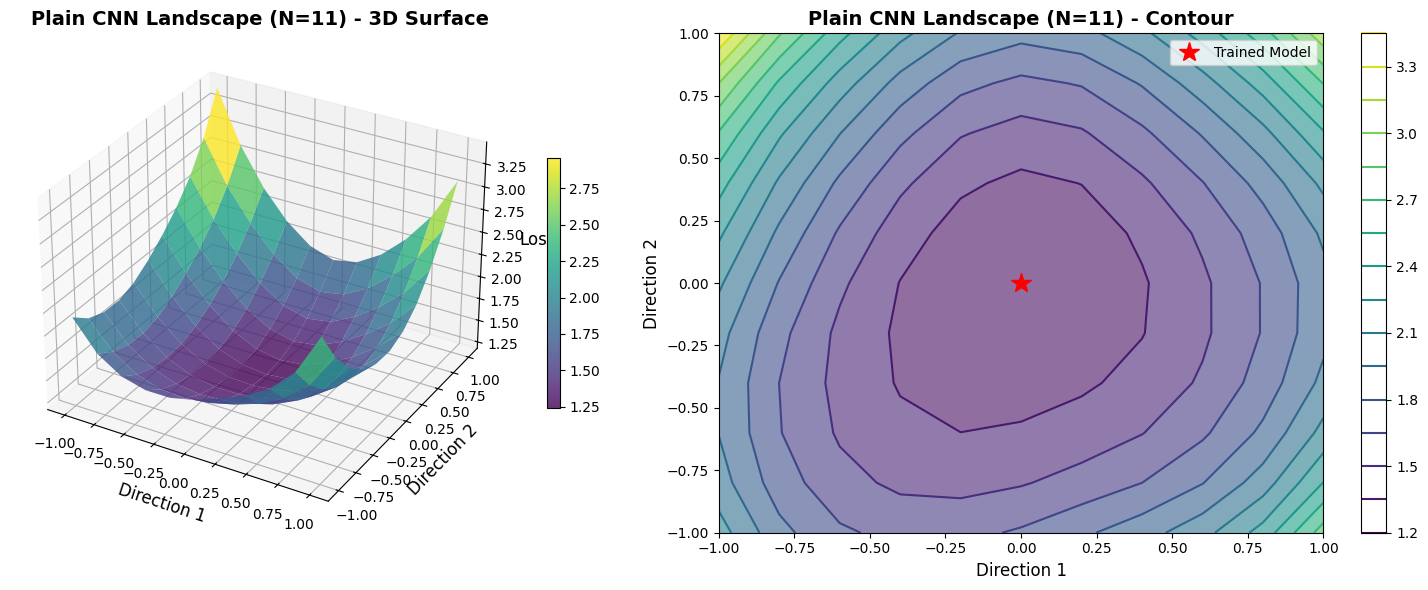


EXPERIMENT 2: ResNet Landscape (QUICK)

Training for 1 epochs...


Epoch 1: Train Acc=53.42%, Test Acc=53.13%

GENERATING 2D LOSS LANDSCAPE

Applying filter normalization...
✓ Filter normalization applied

Evaluating loss at 121 points...


Grid evaluation: 100%|██████████| 121/121 [00:08<00:00, 14.92it/s]


✓ Landscape generation complete!
  Min loss: 1.2945
  Max loss: 6468.8250
  Mean loss: 281.5497

Plot saved to landscape_resnet_quick.png


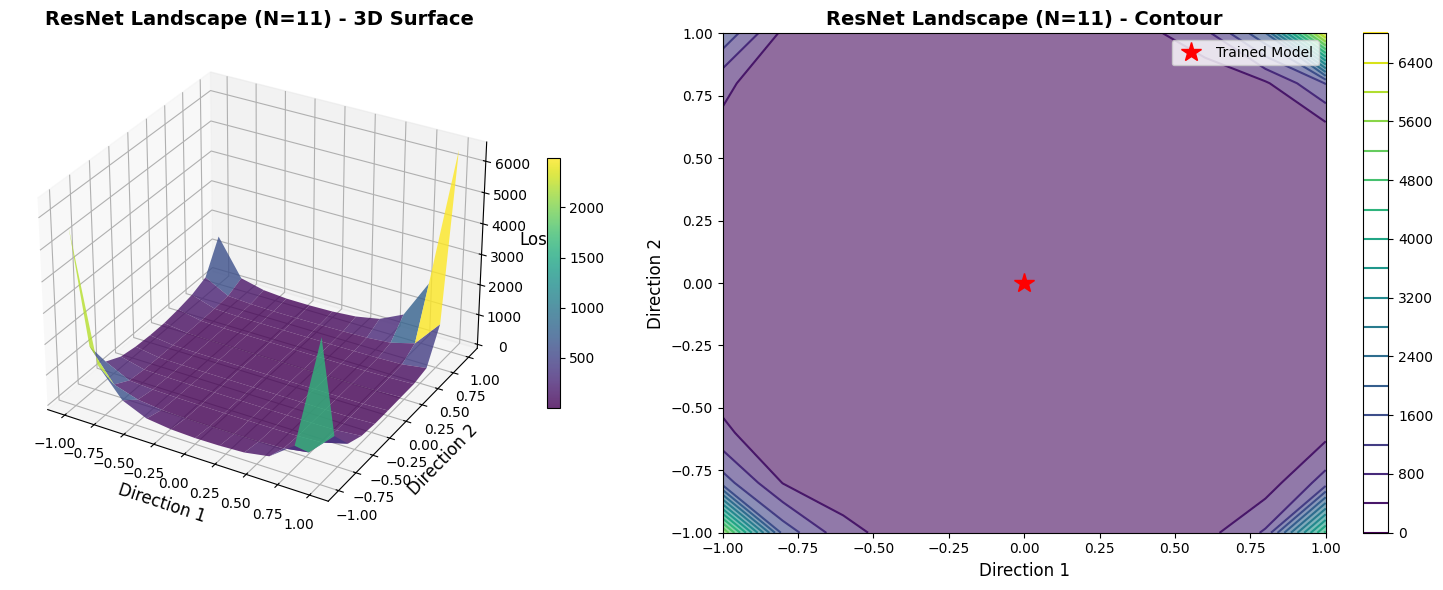


COMPARISON: Plain CNN vs ResNet (QUICK)

Comparison plot saved to landscape_comparison_quick.png


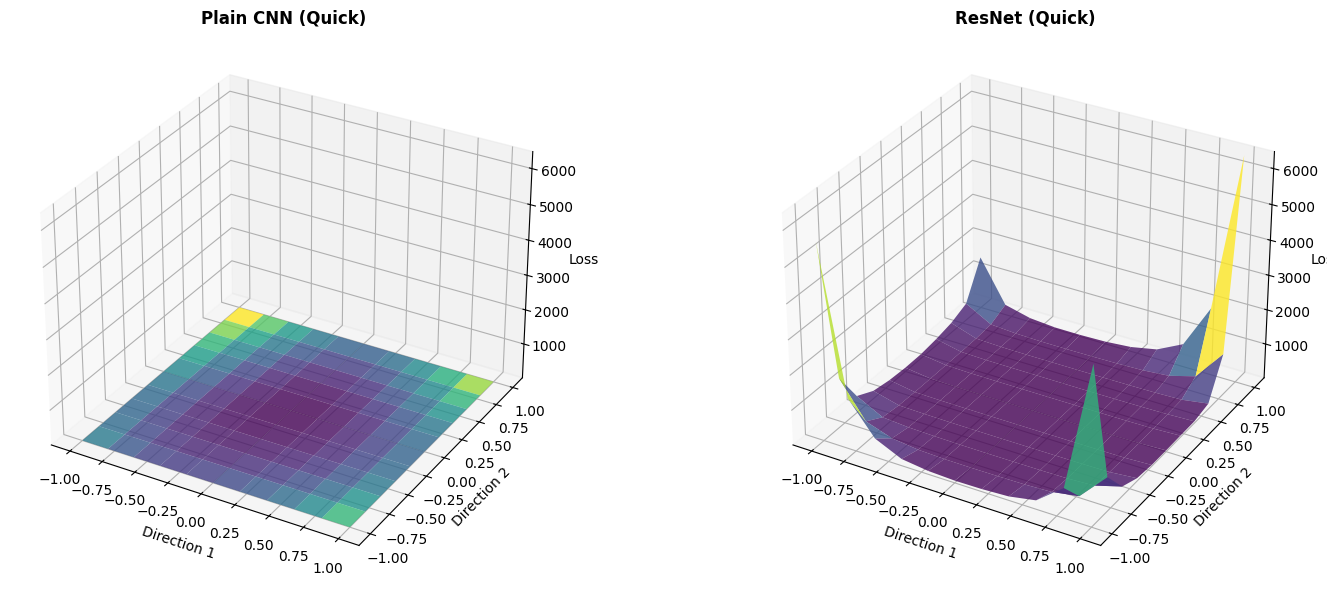


Landscape Statistics (Quick Run):
Plain CNN:
  Loss range: [1.2215, 3.4397]
  Loss variance: 0.1943

ResNet:
  Loss range: [1.2945, 6468.8250]
  Loss variance: 821697.8535

QUICK VISUALIZATION COMPLETE!



In [1]:
"""
FILE 2: landscape_visualization_2d.py
2D Loss Landscape Visualization using Filter-Normalized Random Projections

Based on: Li et al. (2018) "Visualizing the Loss Landscape of Neural Networks"
"""

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import copy
from tqdm import tqdm
import json

# ============================================================================
# PART 1: LANDSCAPE VISUALIZATION CLASS
# ============================================================================

class LandscapeVisualizer:
    """
    Visualize loss landscape in 2D using filter-normalized random projections
    
    Key Innovation (Li et al. 2018): Filter normalization prevents artificial
    flattening of landscapes due to scale differences between layers
    """
    
    def __init__(self, model, criterion, device='cuda'):
        self.model = model
        self.criterion = criterion
        self.device = device
        self.model.to(device)
    
    def get_parameters(self):
        """Extract all parameters as a flat vector"""
        return torch.cat([p.data.view(-1) for p in self.model.parameters()])
    
    def set_parameters(self, params_flat):
        """Set model parameters from a flat vector"""
        offset = 0
        for p in self.model.parameters():
            numel = p.numel()
            p.data = params_flat[offset:offset+numel].view_as(p.data)
            offset += numel
    
    def get_random_direction(self):
        """Generate random direction vector"""
        direction = torch.randn_like(self.get_parameters())
        return direction / torch.norm(direction)
    
    def filter_normalize_direction(self, direction):
        """
        CRITICAL: Filter normalization (Li et al. 2018)
        
        Scale each layer's direction to match the norm of that layer's weights.
        Without this, visualizations are meaningless!
        
        For each layer l:
            direction[l] = direction[l] * (||weights[l]|| / ||direction[l]||)
        """
        offset = 0
        normalized_direction = torch.zeros_like(direction)
        
        for p in self.model.parameters():
            numel = p.numel()
            
            # Extract this layer's direction
            d_layer = direction[offset:offset+numel]
            
            # Compute norms
            weight_norm = torch.norm(p.data.view(-1))
            direction_norm = torch.norm(d_layer)
            
            # Scale direction to match weight norm
            if direction_norm > 1e-10:
                normalized_d = d_layer * (weight_norm / direction_norm)
            else:
                normalized_d = d_layer
            
            normalized_direction[offset:offset+numel] = normalized_d
            offset += numel
        
        return normalized_direction
    
    def evaluate_loss(self, dataloader, max_batches=None):
        """Evaluate average loss on dataset"""
        self.model.eval()
        total_loss = 0.0
        num_batches = 0
        
        with torch.no_grad():
            for i, (inputs, targets) in enumerate(dataloader):
                if max_batches and i >= max_batches:
                    break
                
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                total_loss += loss.item()
                num_batches += 1
        
        return total_loss / num_batches
    
    def create_2d_landscape(
        self, 
        dataloader, 
        direction1=None, 
        direction2=None,
        distance=1.0,
        grid_size=25,
        filter_normalize=True,
        verbose=True
    ):
        """
        Create 2D slice of loss landscape
        
        Args:
            dataloader: Data for loss evaluation
            direction1, direction2: Random directions (generated if None)
            distance: How far to move in each direction
            grid_size: Number of points in each dimension (25×25 = 625 evaluations)
            filter_normalize: Apply filter normalization (RECOMMENDED!)
            verbose: Print progress
        
        Returns:
            loss_grid: 2D array of loss values
            alphas, betas: Grid coordinates
        """
        if verbose:
            print("\n" + "="*70)
            print("GENERATING 2D LOSS LANDSCAPE")
            print("="*70 + "\n")
        
        # Save original parameters
        original_params = self.get_parameters().clone()
        
        # Generate random orthogonal directions
        if direction1 is None:
            direction1 = self.get_random_direction()
        
        if direction2 is None:
            direction2 = self.get_random_direction()
            # Gram-Schmidt orthogonalization
            direction2 = direction2 - torch.dot(direction1, direction2) * direction1
            direction2 = direction2 / torch.norm(direction2)
        
        # Filter normalization (CRITICAL!)
        if filter_normalize:
            if verbose:
                print("Applying filter normalization...")
            direction1 = self.filter_normalize_direction(direction1)
            direction2 = self.filter_normalize_direction(direction2)
            if verbose:
                print("✓ Filter normalization applied\n")
        else:
            if verbose:
                print("WARNING: Filter normalization disabled - results may be misleading!\n")
        
        # Create grid
        alphas = np.linspace(-distance, distance, grid_size)
        betas = np.linspace(-distance, distance, grid_size)
        loss_grid = np.zeros((grid_size, grid_size))
        
        # Evaluate loss at each grid point
        total_evaluations = grid_size * grid_size
        if verbose:
            print(f"Evaluating loss at {total_evaluations} points...")
            pbar = tqdm(total=total_evaluations, desc="Grid evaluation")
        
        for i, alpha in enumerate(alphas):
            for j, beta in enumerate(betas):
                # Move in parameter space
                new_params = original_params + alpha * direction1 + beta * direction2
                self.set_parameters(new_params)
                
                # Evaluate loss
                loss = self.evaluate_loss(dataloader, max_batches=10)
                loss_grid[i, j] = loss
                
                if verbose:
                    pbar.update(1)
        
        if verbose:
            pbar.close()
        
        # Restore original parameters
        self.set_parameters(original_params)
        
        if verbose:
            print(f"✓ Landscape generation complete!")
            print(f"  Min loss: {loss_grid.min():.4f}")
            print(f"  Max loss: {loss_grid.max():.4f}")
            print(f"  Mean loss: {loss_grid.mean():.4f}\n")
        
        return loss_grid, alphas, betas


# ============================================================================
# PART 2: VISUALIZATION FUNCTIONS
# ============================================================================

def plot_2d_landscape(loss_grid, alphas, betas, title="Loss Landscape", 
                     save_path=None, show_contour=True):
    """
    Plot 2D loss landscape as both 3D surface and contour plot
    """
    X, Y = np.meshgrid(alphas, betas)
    
    if show_contour:
        fig = plt.figure(figsize=(16, 6))
        
        # 3D surface plot
        ax1 = fig.add_subplot(121, projection='3d')
        surf = ax1.plot_surface(
            X, Y, loss_grid, 
            cmap=cm.viridis, 
            alpha=0.8,
            linewidth=0,
            antialiased=True
        )
        ax1.set_xlabel('Direction 1', fontsize=12)
        ax1.set_ylabel('Direction 2', fontsize=12)
        ax1.set_zlabel('Loss', fontsize=12)
        ax1.set_title(f'{title} - 3D Surface', fontsize=14, fontweight='bold')
        fig.colorbar(surf, ax=ax1, shrink=0.5)
        
        # Contour plot
        ax2 = fig.add_subplot(122)
        contour = ax2.contour(X, Y, loss_grid, levels=20, cmap='viridis')
        ax2.contourf(X, Y, loss_grid, levels=20, cmap='viridis', alpha=0.6)
        ax2.set_xlabel('Direction 1', fontsize=12)
        ax2.set_ylabel('Direction 2', fontsize=12)
        ax2.set_title(f'{title} - Contour', fontsize=14, fontweight='bold')
        ax2.plot(0, 0, 'r*', markersize=15, label='Trained Model')
        ax2.legend()
        fig.colorbar(contour, ax=ax2)
    else:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(
            X, Y, loss_grid, 
            cmap=cm.viridis,
            alpha=0.8,
            linewidth=0,
            antialiased=True
        )
        ax.set_xlabel('Direction 1', fontsize=12)
        ax.set_ylabel('Direction 2', fontsize=12)
        ax.set_zlabel('Loss', fontsize=12)
        ax.set_title(title, fontsize=14, fontweight='bold')
        fig.colorbar(surf, ax=ax, shrink=0.5)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Plot saved to {save_path}")
    
    plt.show()


def compare_landscapes(landscapes_dict, save_path=None):
    """
    Compare loss landscapes of multiple architectures side-by-side
    
    Args:
        landscapes_dict: {name: (loss_grid, alphas, betas)}
    """
    n_landscapes = len(landscapes_dict)
    fig = plt.figure(figsize=(8*n_landscapes, 6))
    
    for idx, (name, (loss_grid, alphas, betas)) in enumerate(landscapes_dict.items()):
        X, Y = np.meshgrid(alphas, betas)
        
        ax = fig.add_subplot(1, n_landscapes, idx+1, projection='3d')
        surf = ax.plot_surface(
            X, Y, loss_grid,
            cmap=cm.viridis,
            alpha=0.8,
            linewidth=0,
            antialiased=True
        )
        ax.set_xlabel('Direction 1', fontsize=10)
        ax.set_ylabel('Direction 2', fontsize=10)
        ax.set_zlabel('Loss', fontsize=10)
        ax.set_title(name, fontsize=12, fontweight='bold')
        
        # Set same z-axis scale for fair comparison
        all_losses = [grid.min() for _, (grid, _, _) in landscapes_dict.items()]
        max_losses = [grid.max() for _, (grid, _, _) in landscapes_dict.items()]
        ax.set_zlim(min(all_losses), max(max_losses))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Comparison plot saved to {save_path}")
    
    plt.show()


def plot_1d_slice(loss_grid, alphas, betas, slice_type='horizontal', 
                 slice_index=None, title="1D Loss Slice", save_path=None):
    """
    Plot 1D slice through the landscape
    
    Args:
        slice_type: 'horizontal', 'vertical', or 'diagonal'
        slice_index: Which row/column to slice (default: middle)
    """
    if slice_index is None:
        slice_index = len(alphas) // 2
    
    plt.figure(figsize=(10, 6))
    
    if slice_type == 'horizontal':
        losses = loss_grid[slice_index, :]
        coords = betas
        plt.plot(coords, losses, 'b-', linewidth=2)
        plt.xlabel('Direction 2 (β)', fontsize=12)
    elif slice_type == 'vertical':
        losses = loss_grid[:, slice_index]
        coords = alphas
        plt.plot(coords, losses, 'r-', linewidth=2)
        plt.xlabel('Direction 1 (α)', fontsize=12)
    elif slice_type == 'diagonal':
        # Diagonal from bottom-left to top-right
        diagonal_idx = np.arange(min(len(alphas), len(betas)))
        losses = loss_grid[diagonal_idx, diagonal_idx]
        coords = np.linspace(-1, 1, len(diagonal_idx))
        plt.plot(coords, losses, 'g-', linewidth=2)
        plt.xlabel('Diagonal Direction', fontsize=12)
    
    plt.ylabel('Loss', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"1D slice saved to {save_path}")
    
    plt.show()


# ============================================================================
# PART 3: DEMO MODELS
# ============================================================================

class SimpleCNN(nn.Module):
    """Simple CNN without skip connections"""
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


class ResNetBlock(nn.Module):
    """ResNet block with skip connection"""
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out


class SimpleResNet(nn.Module):
    """Simple ResNet with skip connections"""
    def __init__(self, num_classes=10):
        super(SimpleResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.layer1 = self._make_layer(32, 32, 2, stride=1)
        self.layer2 = self._make_layer(32, 64, 2, stride=2)
        self.layer3 = self._make_layer(64, 128, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)
    
    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResNetBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResNetBlock(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


# ============================================================================
# PART 4: TRAINING HELPER
# ============================================================================

def train_model_quick(model, trainloader, testloader, num_epochs=5, lr=0.01, device='cuda'):
    """Quick training for demonstration"""
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    
    print(f"Training for {num_epochs} epochs...")
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for inputs, targets in tqdm(trainloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        
        train_acc = 100. * correct / total
        
        # Evaluate
        model.eval()
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for inputs, targets in testloader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                test_total += targets.size(0)
                test_correct += predicted.eq(targets).sum().item()
        
        test_acc = 100. * test_correct / test_total
        
        print(f"Epoch {epoch+1}: Train Acc={train_acc:.2f}%, Test Acc={test_acc:.2f}%")
    
    return model


# ============================================================================
# PART 5: MAIN EXECUTION
# ============================================================================
# ============================================================================
# PART 5: MAIN EXECUTION (MODIFIED FOR SPEED)
# ============================================================================

def main():
    """
    Main demonstration: Visualize landscapes of different architectures
    (MODIFIED FOR QUICK EXECUTION)
    """
    print("\n" + "="*70)
    print("2D LOSS LANDSCAPE VISUALIZATION (QUICK RUN)")
    print("="*70 + "\n")
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}\n")
    
    # --- ⚙️ SPEED MODIFICATION: Reduce Data Loader overhead ---
    BATCH_SIZE = 64
    NUM_WORKERS = 0 # Set to 0 for quick local runs
    
    # Load CIFAR-10
    print("Loading CIFAR-10...")
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    
    # --- ⚙️ SPEED MODIFICATION: Critical Performance Parameters ---
    QUICK_EPOCHS = 1 # Reduced from 5 to 1
    QUICK_GRID_SIZE = 11 # Reduced from 25 to 11 (625 -> 121 loss evaluations)
    
    # ========================================================================
    # EXPERIMENT 1: Visualize Plain CNN Landscape
    # ========================================================================
    print("\n" + "="*70)
    print("EXPERIMENT 1: Plain CNN Landscape (QUICK)")
    print("="*70 + "\n")
    
    model_cnn = SimpleCNN()
    model_cnn = train_model_quick(model_cnn, trainloader, testloader, num_epochs=QUICK_EPOCHS, device=device)
    
    visualizer_cnn = LandscapeVisualizer(model_cnn, nn.CrossEntropyLoss(), device)
    loss_grid_cnn, alphas, betas = visualizer_cnn.create_2d_landscape(
        testloader,
        distance=1.0,
        grid_size=QUICK_GRID_SIZE, # Reduced
        filter_normalize=True
    )
    
    # Plotting is still useful but can be disabled by commenting out the line below
    plot_2d_landscape(
        loss_grid_cnn, alphas, betas,
        title=f"Plain CNN Landscape (N={QUICK_GRID_SIZE})",
        save_path="landscape_plain_cnn_quick.png"
    )
    
    # ========================================================================
    # EXPERIMENT 2: Visualize ResNet Landscape
    # ========================================================================
    print("\n" + "="*70)
    print("EXPERIMENT 2: ResNet Landscape (QUICK)")
    print("="*70 + "\n")
    
    model_resnet = SimpleResNet()
    model_resnet = train_model_quick(model_resnet, trainloader, testloader, num_epochs=QUICK_EPOCHS, device=device)
    
    visualizer_resnet = LandscapeVisualizer(model_resnet, nn.CrossEntropyLoss(), device)
    loss_grid_resnet, alphas, betas = visualizer_resnet.create_2d_landscape(
        testloader,
        distance=1.0,
        grid_size=QUICK_GRID_SIZE, # Reduced
        filter_normalize=True
    )
    
    # Plotting is still useful but can be disabled by commenting out the line below
    plot_2d_landscape(
        loss_grid_resnet, alphas, betas,
        title=f"ResNet Landscape (N={QUICK_GRID_SIZE})",
        save_path="landscape_resnet_quick.png"
    )
    
    # ========================================================================
    # COMPARISON
    # ========================================================================
    print("\n" + "="*70)
    print("COMPARISON: Plain CNN vs ResNet (QUICK)")
    print("="*70 + "\n")
    
    landscapes = {
        'Plain CNN (Quick)': (loss_grid_cnn, alphas, betas),
        'ResNet (Quick)': (loss_grid_resnet, alphas, betas)
    }
    
    compare_landscapes(landscapes, save_path="landscape_comparison_quick.png")
    
    # Statistics and saving logic remain the same...
    print(f"\nLandscape Statistics (Quick Run):")
    print(f"Plain CNN:")
    print(f"  Loss range: [{loss_grid_cnn.min():.4f}, {loss_grid_cnn.max():.4f}]")
    print(f"  Loss variance: {loss_grid_cnn.var():.4f}")
    print(f"\nResNet:")
    print(f"  Loss range: [{loss_grid_resnet.min():.4f}, {loss_grid_resnet.max():.4f}]")
    print(f"  Loss variance: {loss_grid_resnet.var():.4f}")
    
    print("\n" + "="*70)
    print("QUICK VISUALIZATION COMPLETE!")
    print("="*70 + "\n")


if __name__ == "__main__":
    main()